In [ ]:
import numpy as np
from abc import ABC, abstractmethod
from dataclasses import dataclass

class BoundaryCondition1D(ABC):
  """Abstract base class for 1D boundary conditions."""

  @abstractmethod
  def apply(self, A: np.ndarray, b: np.ndarray, dx: float):
      """
      Modify matrix A and vector b in-place to enforce this boundary condition.
      """
      ...
        
@dataclass
class DirichletBC(BoundaryCondition1D):
  node: int      # index in the grid (0 or N-1)
  value: float   # phi(node) = value

  def apply(self, A: np.ndarray, b: np.ndarray, dx: float):
    N = A.shape[0]
    i = self.node
    A[i, :] = 0.0
    A[i, i] = 1.0
    b[i] = self.value

class DiscreteOperator1D(ABC):
    """
    Abstract base class for discrete 1D operators.
    Represents a linear map acting on grid functions.
    """

    def __init__(self, dx: float, N: int):
        self.dx = float(dx)
        self.N = int(N)

    @abstractmethod
    def stencil(self, i: int):
        """
        Return the coefficients (a_{i,i-1}, a_{i,i}, a_{i,i+1})
        of the operator row acting at interior node i.
        """
        ...


class PoissonOperator1D(DiscreteOperator1D):
    r"""
    Discrete operator P = d/dx ( eps(x) d/dx )
    using a flux-conserving finite-difference stencil.
    """

    def __init__(self, eps: np.ndarray, dx: float):
        eps = np.asarray(eps, dtype=float)
        if eps.ndim != 1:
            raise ValueError("eps must be a 1D array.")
        super().__init__(dx=dx, N=eps.size)
        self.eps = eps

    def stencil(self, i: int):
        """
        Poisson stencil at node i:
        a_{i,i-1}, a_{i,i}, a_{i,i+1}.
        """
        eps = self.eps
        dx = self.dx

        eps_imh = 0.5 * (eps[i] + eps[i - 1])  # epsilon at i-1/2
        eps_iph = 0.5 * (eps[i] + eps[i + 1])  # epsilon at i+1/2

        a_im1 =  eps_imh / dx**2
        a_i   = -(eps_imh + eps_iph) / dx**2
        a_ip1 =  eps_iph / dx**2

        return a_im1, a_i, a_ip1
    
       

class PoissonOperator1D:
    """Discrete operator P = d/dx ( eps d/dx )."""

    def __init__(self, eps: np.ndarray, dx: float):
        self.eps = eps
        self.dx = dx

    def row(self, i: int):
        """
        Return the operator coefficients (a_{i,i-1}, a_{i,i}, a_{i,i+1})
        corresponding to the Poisson operator acting at node i.
        """
        eps = self.eps
        dx = self.dx

        eps_imh = 0.5 * (eps[i] + eps[i - 1])  # epsilon at i-1/2
        eps_iph = 0.5 * (eps[i] + eps[i + 1])  # epsilon at i+1/2

        a_im1 =  eps_imh / dx**2
        a_i   = -(eps_imh + eps_iph) / dx**2
        a_ip1 =  eps_iph / dx**2

        return a_im1, a_i, a_ip1



In [ ]:
import numpy as np



class Poisson1D:
  """
  Solve d/dx ( eps(x) dphi/dx ) = -rho(x) on [x[0], x[-1]]
  with Dirichlet boundary conditions phi(x[0]) = phi_L, phi(x[-1]) = phi_R.

  Parameters
  ----------
  x : np.ndarray
      1D grid points (assumed uniformly spaced, increasing).
  eps_func : callable
      Function eps_func(x) -> epsilon(x).
  rho_func : callable
      Function rho_func(x) -> rho(x).
  """

  def __init__(self, x: np.ndarray, eps_func, rho_func):
    x = np.asarray(x, dtype=float)
    if x.ndim != 1:
        raise ValueError("x must be a 1D array.")
    if x.size < 3:
        raise ValueError("Need at least 3 points for a 2nd-order stencil.")

    # Check uniform spacing (optional but good for sanity)
    dx_all = np.diff(x)
    if not np.allclose(dx_all, dx_all[0]):
        raise ValueError("x must be uniformly spaced for this solver.")

    self.x = x
    self.dx = dx_all[0]
    self.N = x.size

    self.eps = eps_func(self.x)  # epsilon at nodes
    self.rho = rho_func(self.x)  # rho at nodes

    if self.eps.shape != self.x.shape:
        raise ValueError("eps_func(x) must return array of same shape as x.")
    if self.rho.shape != self.x.shape:
        raise ValueError("rho_func(x) must return array of same shape as x.")

    def assemble(self, phi_L: float, phi_R: float):
      N, dx = self.N, self.dx
      eps, rho = self.eps, self.rho

      A = np.zeros((N, N), dtype=float)
      b = np.zeros(N, dtype=float)

      # Interior nodes (flux-conserving)
      for i in range(1, N - 1):
          eps_imh = 0.5 * (eps[i] + eps[i - 1])
          eps_iph = 0.5 * (eps[i] + eps[i + 1])

          A[i, i - 1] =  eps_imh / dx**2
          A[i, i]     = -(eps_imh + eps_iph) / dx**2
          A[i, i + 1] =  eps_iph / dx**2

          b[i] = -rho[i] * dx**2

      # Apply boundary conditions (overwrite the corresponding rows)
      for bc in self.bcs:
          bc.apply(A, b, dx)

      self.A = A
      self.b = b

      return A, b

    def solve(self, phi_L: float, phi_R: float):
        A, b = self.assemble(phi_L, phi_R)
        phi = np.linalg.solve(A, b)
        return self.x, phi


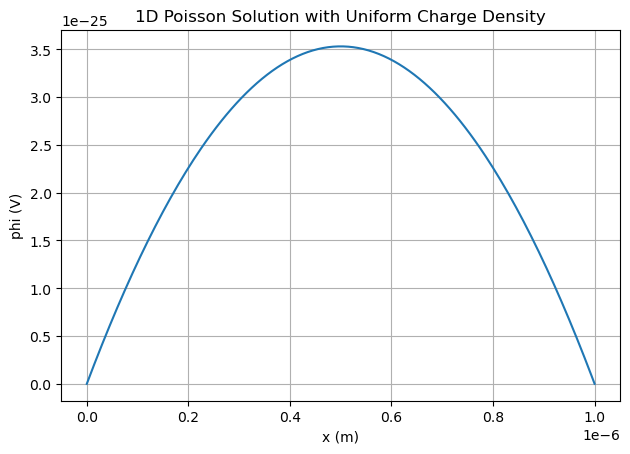

In [10]:
L = 1e-6
N = 201
x = np.linspace(0.0, L, N)

eps0 = 8.854e-12
rho0 = 1e-6

eps_func = lambda x: eps0 * np.ones_like(x)
rho_func = lambda x: rho0 * np.ones_like(x)

solver = Poisson1D(x=x, eps_func=eps_func, rho_func=rho_func)
x_grid, phi = solver.solve(phi_L=0.0, phi_R=0.0)

import matplotlib.pyplot as plt
# Plot
fig, ax = plt.subplots(1,1)
ax.plot(x_grid, phi)
ax.set_xlabel("x (m)")
ax.set_ylabel("phi (V)")
ax.set_title("1D Poisson Solution with Uniform Charge Density")
ax.grid(True)
fig.tight_layout()

